
See simple test example [here](https://colab.research.google.com/drive/1wrCl6bTQWNVMQj0U54vVdXMOx4mDf5_d#scrollTo=cOZV2reX1zDJ)<br><br>
NHD analysis from GIS (based on channels_nwm_v12_routeLink)<br>
Total number of channel segments:2,729,077<br>
1 Order 10 terminal segments (total: 441)<br>
2 Order 9 terminal segments (total: 3,334)<br>
4 Order 8 terminal segments (total: 7,495)<br>
31 Order 7 terminal segments (total: 20,956)<br>
87 Order 6 terminal segments (total: 48,275)<br>
230 Order 5 terminal segments (total: 91,386)<br>
987 Order 4 terminal segments (total: 170,417)<br>
1972 Order 3 terminal segments (total: 315,289)<br>
5788 Order 2 terminal segments (total: 598,992)<br>
5611 Order 1 terminal segments (total: 1,472,492)<br>

##Define functions



In [0]:
#Fundamental data structures, QUEUE used for BFS
class node:
    def __init__(self, val):
        self.val = val
        self.next = None
class QUEUE:
    def __init__(self):
        self.head = None
        self.tail = None
        self.size = 0
    def enq(self, val):
        self.size += 1
        val = node(val)
        if (self.head == None):
            self.head = val
            self.tail = val
        else:
            self.tail.next = val
            self.tail = val
    def deq(self):
        send = self.head
        self.head = self.head.next
        self.size -= 1
        return send
    def qsize(self):
        return self.size
class STACK:
    def __init__(self):
        self.size = 0
        self.top = -1
        self.data = []
    def push(self, val):
        self.data.append(val)
        self.top += 1
        self.size += 1
    def pop(self):
        if self.size == 0:
            return None
        val = self.data[self.top]
        self.top -= 1
        self.size -= 1
        return val
    def size(self):
        return self.size

In [0]:
#BFS
#Number of reaches equal to number of junctions plus number of head waters
def getNumReaches(terminalKeys, upConDict, headwaterKeys, termCode):
    numReaches = 0
    for terminal in terminalKeys:
        q = QUEUE()
        q.enq(terminal)
        while q.size > 0:
            curNode = q.deq().val
            if curNode in upConDict and curNode != termCode:
                numReaches += len(upConDict[curNode]["upstreams"]) - 1
                for connection in upConDict[curNode]["upstreams"]:
                    q.enq(connection)
    numReaches += len(headwaterKeys)
    return numReaches

In [0]:
#Refactored build_connections function
def buildConnections(test_rows, featureID, keyLen, keyTo, termKey):
    up = {}
    down = {}
    allKeys = []
    ref_keys = []
    head_keys = []
    term_keys = []
    for row in test_rows:
        allKeys.append(row[featureID])
        ref_keys.append(row[keyTo])
        if row[keyTo] == termKey:
            term_keys.append(row[featureID])
        down[row[featureID]] = {"downstream": row[keyTo], "length": row[keyLen]}
        if row[keyTo] not in up:
            up[row[keyTo]] = {"upstreams": [row[featureID]], "length": row[keyLen]}
        else:
            up[row[keyTo]]["upstreams"].append(row[featureID])
    
    head_keys = [x for x in allKeys if x not in ref_keys]
    for key in head_keys:
        up[key] = {"upstreams": [termKey], "length": down[key]["length"]}
    for key in up:
        if key != termKey and key in down.keys():
            up[key]["length"] = down[key]["length"]
        else:
            up[key]["length"] = -1
    return allKeys, ref_keys, head_keys, term_keys, down, up

In [0]:
# NOTE: these methods can lose the "connections" and "rows" arguments when 
# implemented as class methods where those arrays are members of the class.
def recurse_downstream(key, rows, key_col, downstream_col, length_col, down_connections, terminal_code):
    for row in rows:
        # print(f'{key_col}  {key}')
        if row[key_col] == key:
            down_connections[key] = {'downstream': row[downstream_col], 'length': row[length_col] }
            if not key == terminal_code:
                recurse_downstream(row[downstream_col], rows, key_col, downstream_col, length_col, down_connections, terminal_code)

def build_connections(rows, key_col, downstream_col, length_col, down_connections, up_connections, terminal_code):
    # Get the upstream nodes to start with
    all_keys = [row[key_col] for row in rows]
    ref_keys = [row[downstream_col] for row in rows]
    headwater_keys = [x for x in all_keys if x not in ref_keys]
    
    # Get the downstream terminating nodes
    terminal_keys = []
    for row in rows:
        if row[downstream_col] == terminal_code:
            terminal_keys.append(row[key_col])

    # Recursive call to go all the way down the relationship
    for key in headwater_keys:
        recurse_downstream(key = key
             , rows = rows
             , key_col = key_col
             , downstream_col = downstream_col
             , length_col = length_col
             , down_connections = down_connections
             , terminal_code = terminal_code)

    # Create inverse of connections looking upstream
    for i in headwater_keys:
        up_connections[i] = { 'upstreams': [terminal_code], 'length': down_connections[i]['length'] }

    for i in down_connections.keys():
        if not down_connections[i]['downstream'] == terminal_code:
            up_connections[down_connections[i]['downstream']] = { 'upstreams': [], 'length': down_connections[i]['length'] }
                                    #  `down_connections[down_connections[i]['downstream']]['length']` to just `down_connections[i]['length']`
            for j in down_connections.keys():
                if down_connections[i]['downstream'] == down_connections[j]['downstream']:
                    up_connections[down_connections[i]['downstream']]['upstreams'].append(j)

    return all_keys, ref_keys, headwater_keys, terminal_keys, down_connections, up_connections

In [0]:
def rec_print_down(key, down_connections, terminal_code):
    if key == terminal_code: return

    print(f"{key} with length {down_connections[key]['length']}")
    rec_print_down(down_connections[key]['downstream'], down_connections, terminal_code)


In [0]:
def rec_print_up(keys, tab_count, up_connections, down_connections, terminal_code):
    if not isinstance(keys, list): keys = [keys]
    tab_count += 1
    for key in keys:
        if not key == terminal_code:
            print(f"{'.' * (tab_count)}\\{key} with length {down_connections[key]['length']}\\")
            rec_print_up(up_connections[key]['upstreams'], tab_count, up_connections, down_connections, terminal_code)



##TEST

In [33]:
 # Test data
test_rows = [
    [0,456,-999,0],
    [1,178,4,0],
    [2,394,0,0],
    [3,301,2,0],
    [4,798,0,0],
    [5,679,4,0],
    [6,523,0,0],
    [7,815,2,0],
    [8,841,-999,0],
    [9,514,12,0],
    [10,458,9,0],
    [11,832,8,0],
    [12,543,8,0],
    [13,240,14,0],
    [14,548,10,0],
    [15,920,14,0],
]

test_key_col = 0
test_downstream_col = 2
test_length_col = 1
test_terminal_code = -999

test_down_connections = {}
test_up_connections = {}

#(test_all_keys, test_ref_keys, test_headwater_keys
# , test_terminal_keys, test_down_connections
# , test_up_connections) = build_connections(
#             rows = test_rows
#             , key_col = test_key_col
#             , downstream_col = test_downstream_col
#             , length_col = test_length_col
#             , down_connections = test_down_connections
#             , up_connections = test_up_connections
#             , terminal_code = test_terminal_code)

(test_all_keys, test_ref_keys, test_headwater_keys
 , test_terminal_keys, test_down_connections
 , test_up_connections) = buildConnections(
     test_rows, test_key_col, test_length_col, test_downstream_col
     , test_terminal_code)

print(test_all_keys)
print(test_ref_keys)
print(test_headwater_keys)
print(test_terminal_keys)
print(test_down_connections)
print(test_up_connections)

print(getNumReaches(test_terminal_keys, test_up_connections, test_headwater_keys, test_terminal_code))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[-999, 4, 0, 2, 0, 4, 0, 2, -999, 12, 9, 8, 8, 14, 10, 14]
[1, 3, 5, 6, 7, 11, 13, 15]
[0, 8]
{0: {'downstream': -999, 'length': 456}, 1: {'downstream': 4, 'length': 178}, 2: {'downstream': 0, 'length': 394}, 3: {'downstream': 2, 'length': 301}, 4: {'downstream': 0, 'length': 798}, 5: {'downstream': 4, 'length': 679}, 6: {'downstream': 0, 'length': 523}, 7: {'downstream': 2, 'length': 815}, 8: {'downstream': -999, 'length': 841}, 9: {'downstream': 12, 'length': 514}, 10: {'downstream': 9, 'length': 458}, 11: {'downstream': 8, 'length': 832}, 12: {'downstream': 8, 'length': 543}, 13: {'downstream': 14, 'length': 240}, 14: {'downstream': 10, 'length': 548}, 15: {'downstream': 14, 'length': 920}}
{-999: {'upstreams': [0, 8], 'length': -1}, 4: {'upstreams': [1, 5], 'length': 798}, 0: {'upstreams': [2, 4, 6], 'length': 456}, 2: {'upstreams': [3, 7], 'length': 394}, 12: {'upstreams': [9], 'length': 543}, 9: {'upstreams': [10], 'length': 

In [34]:

print("########################")
print("Downstream Connections")
print("########################")
for key in test_headwater_keys:
    rec_print_down(key, test_down_connections, test_terminal_code)
    print("########################")

print("")


########################
Downstream Connections
########################
1 with length 178
4 with length 798
0 with length 456
########################
3 with length 301
2 with length 394
0 with length 456
########################
5 with length 679
4 with length 798
0 with length 456
########################
6 with length 523
0 with length 456
########################
7 with length 815
2 with length 394
0 with length 456
########################
11 with length 832
8 with length 841
########################
13 with length 240
14 with length 548
10 with length 458
9 with length 514
12 with length 543
8 with length 841
########################
15 with length 920
14 with length 548
10 with length 458
9 with length 514
12 with length 543
8 with length 841
########################



In [35]:

print("########################")
print("Upstream Connections")
print("########################")
for key in test_terminal_keys:
    rec_print_up([key], -1, test_up_connections, test_down_connections, test_terminal_code)
    print("########################")

########################
Upstream Connections
########################
\0 with length 456\
.\2 with length 394\
..\3 with length 301\
..\7 with length 815\
.\4 with length 798\
..\1 with length 178\
..\5 with length 679\
.\6 with length 523\
########################
\8 with length 841\
.\11 with length 832\
.\12 with length 543\
..\9 with length 514\
...\10 with length 458\
....\14 with length 548\
.....\13 with length 240\
.....\15 with length 920\
########################


##NHD Subset (Brazos/Lower Colorado)

In [36]:
import sys
try:
    import google.colab
    IN_COLAB = True
    # !git clone https://github.com/jameshalgren/wrf_hydro_nwm_public.git
    !git clone https://github.com/camarongeorge/wrf_hydro_nwm_public.git small
    # sys.path.append('/content/small/trunk/NDHMS/dynamic_channel_routing/test/input/text/Channels')
except:
    IN_COLAB = False
    # sys.path.append(r'../src')
    
!pip install geopandas

fatal: destination path 'small' already exists and is not an empty directory.


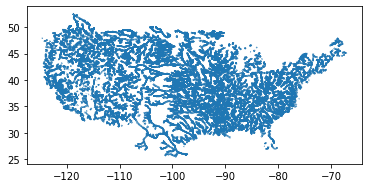

In [43]:
import geopandas as gpd
import numpy as np

# nhd_conus = gpd.read_file('/content/small/trunk/NDHMS/dynamic_channel_routing/test/input/geo/Channels/NHD_BrazosLowerColorado_Channels.shp')
nhd_conus = gpd.read_file('/content/small/trunk/NDHMS/dynamic_channel_routing/test/input/geo/Channels/NHD_Conus_Channels.shp')
nhd_conus.plot()

In [44]:
nhd_conus.head()

,OBJECTID,featureID,linkDim,link,order_,Length,to,MusK,MusX,So,n,BtmWdth,ChSlp,Qi,gages,NHDWaterbo,lat,lon,alt,Kchan,ascendingI,Shape_Leng,geometry
0,2283,328271,388099,328271,8,6685.0,328275,3600.0,0.2,0.0,0.045,85.6765,0.05,0.0,None,-9999,27.1069,-99.4416,92.41,0,1337104,0.062148,"LINESTRING (-99.43063 27.13471, -99.43124 27.1..."
1,2284,328275,388100,328275,8,4464.0,1131002478,3600.0,0.2,0.0,0.045,85.6826,0.05,0.0,None,-9999,27.0684,-99.4481,91.68,0,1191151,0.041935,"LINESTRING (-99.43195 27.08172, -99.43532 27.0..."
2,2287,328285,388172,328285,8,2291.0,1131002488,3600.0,0.2,0.0,0.045,85.8518,0.05,0.0,None,120051895,26.9912,-99.3936,91.68,0,1317845,0.021690,"LINESTRING (-99.39823 27.00032, -99.39863 26.9..."
3,2290,625322,392961,625322,8,441.0,625372,3600.0,0.2,0.0,0.045,100.2780,0.05,0.0,None,-9999,26.1160,-98.2670,24.86,0,1319219,0.004276,"LINESTRING (-98.26538 26.11741, -98.26544 26.1..."
4,2291,625326,392956,625326,8,966.0,625370,3600.0,0.2,0.0,0.045,100.2760,0.05,0.0,None,-9999,26.1094,-98.3036,25.52,0,1316348,0.009040,"LINESTRING (-98.30100 26.10593, -98.30102 26.1..."


In [0]:
nhd_conus_rows = nhd_conus.to_numpy()


In [46]:
key_col_NHD = 1
downstream_col_NHD = 6
length_col_NHD = 5
terminal_code_NHD = 0

down_connections_NHD = {}
up_connections_NHD = {}

# Kick off recursive call for all connections and keys
#(all_keys_NHD, ref_keys_NHD, headwater_keys_NHD
# , terminal_keys_NHD, down_connections_NHD
# , up_connections_NHD) = build_connections(
#             rows = nhd_conus_rows
#             , key_col = key_col_NHD
#             , downstream_col = downstream_col_NHD
#             , length_col = length_col_NHD
#             , down_connections = down_connections_NHD
#             , up_connections = up_connections_NHD
#             , terminal_code = terminal_code_NHD)

(all_keys_NHD, ref_keys_NHD, headwater_keys_NHD
 , terminal_keys_NHD, down_connections_NHD
 , up_connections_NHD) = buildConnections(
     nhd_conus_rows, key_col_NHD, length_col_NHD
     , downstream_col_NHD, terminal_code_NHD
 )

print(all_keys_NHD)
print(ref_keys_NHD)
print(headwater_keys_NHD)
print(terminal_keys_NHD)
print(down_connections_NHD)
print(up_connections_NHD)

numReaches = getNumReaches(terminal_keys_NHD, up_connections_NHD, headwater_keys_NHD, terminal_code_NHD)
print("There are {} reaches in this dataset".format(numReaches))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



There are 4655 reaches in this dataset


In [0]:
for key, value in up_connections_NHD.items():
    if len(value['upstreams']) > 1:
    # if 1 == 1:
        # print (link, link['upstreams'][:])
        print (key, value['upstreams'])

In [42]:
print(down_connections_NHD)
print(up_connections_NHD)

{3764288: {'downstream': 3764296, 'length': 2150.0}, 3764296: {'downstream': 3765756, 'length': 1277.0}, 3766380: {'downstream': 3766382, 'length': 431.0}, 3765756: {'downstream': 3766380, 'length': 1274.0}, 3765796: {'downstream': 3765798, 'length': 219.0}, 3765798: {'downstream': 3766370, 'length': 200.0}, 3766370: {'downstream': 3766384, 'length': 592.0}, 3766384: {'downstream': 3766386, 'length': 763.0}, 3765764: {'downstream': 3765748, 'length': 171.0}, 3766382: {'downstream': 3765764, 'length': 293.0}, 3765770: {'downstream': 3765774, 'length': 972.0}, 3765774: {'downstream': 3765780, 'length': 782.0}, 3765792: {'downstream': 3766354, 'length': 1808.0}, 3766354: {'downstream': 3766356, 'length': 829.0}, 3766336: {'downstream': 3766324, 'length': 43.0}, 3766342: {'downstream': 0, 'length': 496.0}, 3766346: {'downstream': 3766342, 'length': 1980.0}, 3766348: {'downstream': 3766346, 'length': 4996.0}, 3766330: {'downstream': 3766348, 'length': 2821.0}, 3766332: {'downstream': 376633

In [50]:
print(len(down_connections_NHD))   
print(len(up_connections_NHD))   

171887
171888


In [0]:
for row in nhd_conus_rows[0:20]:
    print(f'{row[key_col_NHD]}   {key_col_NHD}  {row[downstream_col_NHD]}')

In [0]:

print("########################")
print("Downstream Connections")
print("########################")
for key in headwater_keys_NHD:
    rec_print_down(key, down_connections_NHD, terminal_code_NHD)
    print("########################")

print("")


In [0]:

print(up_connections_NHD)
print(down_connections_NHD)
print("########################")
print("Upstream Connections")
print("########################")
for key in terminal_keys_NHD:
    rec_print_up([key], -1, up_connections_NHD, down_connections_NHD, terminal_code_NHD)
    print("########################")